# PyPerceive to select and load Percept recordings 

## 0a. Loading default packages and functions

In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
from scipy import signal

import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 

from importlib import reload          


#### check package versions

developed with:
- Python sys 3.10.8
- pandas 1.5.1
- numpy 1.23.4
- mne_bids 0.11.1
- mne 1.2.3

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne_bids', mne_bids.__version__)
print('mne', mne.__version__)


Python sys 3.10.8 | packaged by conda-forge | (main, Nov 24 2022, 14:07:00) [MSC v.1916 64 bit (AMD64)]
pandas 1.5.1
numpy 1.23.4
mne_bids 0.11.1
mne 1.2.3


## 0b. Loading pyPerceive functions

In [3]:
def add_and_set_code_folder_in_notebook():
    """
    while working in the local pyPerceive repo,
    find and set path to the PyPerceive code folder

    use function in notebook first, to locate the local
    repo and enable import of pyPerceive functions
    """
    project_path = os.getcwd()

    while project_path[-10:] != 'PyPerceive':
        project_path = os.path.dirname(project_path)

    code_path = os.path.join(project_path, 'code')
    sys.path.append(code_path)

    # change directory to code path
    os.chdir(code_path)
    
    return print(f'working dir set to: {code_path}')


In [4]:
## MAIN FUNCTION FOR DATA IMPORT

# change working directory to ensure correct loading of own functions
add_and_set_code_folder_in_notebook()

# import main class to work with
from PerceiveImport.classes import main_class


working dir set to: c:\Users\habetsj\Research\projects\PyPerceive\code


In [5]:
## IMPORT ALL SUB CLASSES AND FUNCTIONS FOR DEBUGGING
from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class, chronic_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers
import PerceiveImport.methods.timezone_handling as tz_handling

### 1. Load Streaming, Survey

In [ ]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

sub024 = main_class.PerceiveData(
    sub = "024", 
    incl_modalities=['survey', 'streaming', 'indefiniteStreaming'],
    incl_session = ["fu18m"],
    incl_condition =['m0s0'],
    incl_task = ["rest"],
    incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    # use_bids=True,  # TODO: add to functionality
)


In [ ]:
sub024.streaming.fu18m.m0s0.rest.run1.data

In [ ]:
sub024.survey.fu18m.m0s0.rest.SegmInterR.run1.data.get_data()

### 2. Loading Chronic

In [6]:
# in case of debugging
from PerceiveImport.methods import extract_chronic_timeline_samples as extract_chronic

In [7]:
chronic_subs = ['039', '040', '041', '059', '070', ]

In [8]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

importlib.reload(tz_handling)
importlib.reload(extract_chronic)

importlib.reload(chronic_class)

dat = main_class.PerceiveData(
    sub = chronic_subs[-2], 
    incl_modalities=['chronic'],
    import_json=True,
    warn_for_metaNaNs=False,
)


extract chronic data from files: ['Report_Json_Session_Report_20230730T143732.json', 'Report_Json_Session_Report_20230420T103946.json', 'Report_Json_Session_Report_20221101T123506.json', 'Report_Json_Session_Report_20230420T104101.json', 'Report_Json_Session_Report_20221101T123628.json', 'Report_Json_Session_Report_20230421T122159.json']
	...START CHRONIC EXTRACT: Report_Json_Session_Report_20230730T143732.json

Add session 2023-06-28T15:34:46Z from Left hemisphere

Add session 2023-06-29T15:34:46Z from Left hemisphere

Add session 2023-06-30T15:34:46Z from Left hemisphere

Add session 2023-07-01T15:34:46Z from Left hemisphere

Add session 2023-07-02T15:34:46Z from Left hemisphere

Add session 2023-07-03T15:34:46Z from Left hemisphere

Add session 2023-07-04T15:34:46Z from Left hemisphere

Add session 2023-07-05T15:34:46Z from Left hemisphere

Add session 2023-07-06T15:34:46Z from Left hemisphere

Add session 2023-07-07T15:34:46Z from Left hemisphere

Add session 2023-07-08T15:34:46Z f

In [ ]:
type(dat.chronic.data['local_time'].values[0])

In [ ]:
sort_idx = np.argsort(dat.chronic.data['local_time'].values[:300])#[::-1]

dat.chronic.data.iloc[sort_idx, :]

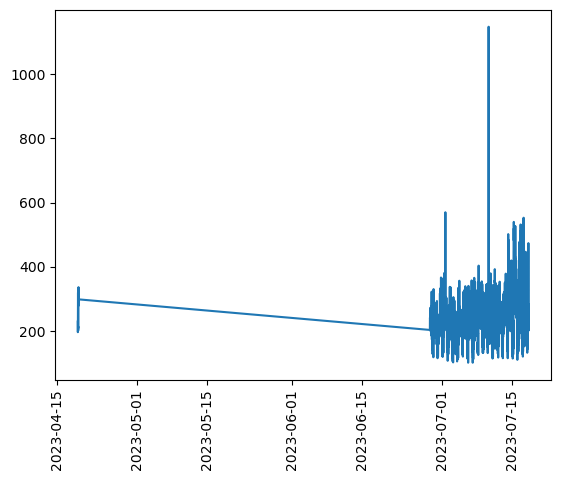

In [9]:
plt.plot(dat.chronic.data['local_time'],
         dat.chronic.data['PSD_Left'])
plt.xticks(rotation=90)
plt.show()

In [10]:
dat_l = dat.chronic.data['PSD_Left'].values
dat_r = dat.chronic.data['PSD_Right'].values
f_l = float(dat.chronic.data['freq_Left'][0])
f_r = float(dat.chronic.data['freq_Right'][0])

In [11]:
import datetime as dt

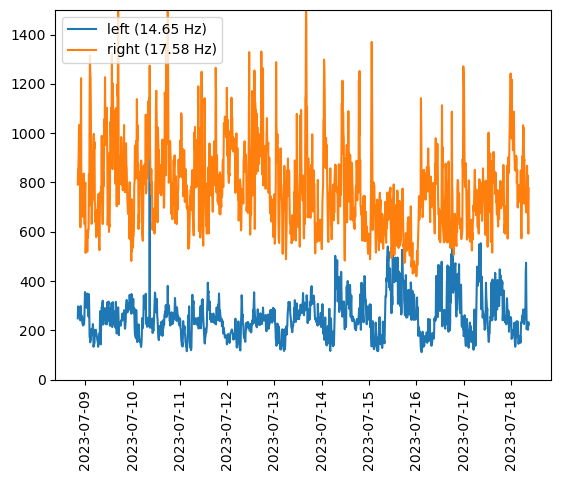

In [12]:
fig, ax = plt.subplots(1,1)

i2 = 1500

times = dat.chronic.data['local_time'].values[i2:]

ax.plot(times, dat_l[i2:], label=f'left ({f_l} Hz)')
ax.plot(times, dat_r[i2:], label=f'right ({f_r} Hz)')

ax.legend(loc='upper left')

ax.set_ylim(0, 1500)

# xticks = np.linspace(0, 1500, 10).astype(int)
# ax.set_xticks(xticks)
# ax.set_xticklabels(np.array(times)[xticks])
ax.tick_params(axis='x', rotation=90)

plt.show()


## 3. Direct access JSONs

In [ ]:
json_fname = 'Report_Json_Session_Report_20230523T113952.json'
j = load_rawfile.load_sourceJSON('047', json_fname)

json_fname = 'Report_Json_Session_Report_20230524T150050.json'
j2 = load_rawfile.load_sourceJSON('047', json_fname)

In [ ]:
def convert_list_string_floats(
    string_list
):
    try:
        floats = [float(v) for v in string_list.split(',')]
    except:
        floats = [float(v) for v in string_list[:-1].split(',')]

    return floats


In [ ]:
print(j.keys())
print(j2.keys())

In [ ]:
prc_data_codes = {
    'signal_test': 'CalibrationTests',
    'streaming': 'BrainSenseTimeDomain',
    'survey': 'LfpMontageTimeDomain',
    'indef_streaming': 'IndefiniteStreaming'
}

In [ ]:
j.keys()

j['BrainSenseLfp'][0]

In [ ]:
# j[prc_data_codes['survey']]  # TO INTEGRATE

check_and_correct_missings_in_lfp(j['BrainSenseLfp'][4])

In [ ]:
mod = 'streaming'

list_of_streamings = j[prc_data_codes[mod]]
n_streamings = len(list_of_streamings)


list_of_streamings2 = j2[prc_data_codes[mod]]

# n_exp_streamings = extract from metadata
# check whether n-streamings match metdata table 
# if n_streamings == n_streamings: ...

for dat in list_of_streamings2:
    print(dat)

In [ ]:
# list_of_streamings[0]['GlobalPacketSizes']

print(list_of_streamings[0].keys())

In [ ]:
dat.keys()

In [ ]:
# dat = list_of_streamings[0]
for i_dat, dat in enumerate(list_of_streamings):
    print(i_dat)
    new_lfp = check_and_correct_missings_in_lfp(dat)


In [ ]:
def check_and_correct_missings_in_lfp(dat: dict):
    """"
    Function checks missing packets based on start and endtime
    of first and last received packets, and the time-differences
    between consecutive packets. In case of a missing packet,
    the missing time window is filled with NaNs.

    WORKS NOW FOR BRAINSENSETIMEDOMAIN DATA STRUCTURE, NOT YET
    FOR BRAINSENSELFP OR SURVEY, STREAMING
    """
    Fs = dat['SampleRateInHz']
    ticksMsec = convert_list_string_floats(dat['TicksInMses'])
    ticksDiffs = np.diff(np.array(ticksMsec))
    data_is_missing = (ticksDiffs != 250).any()
    packetSizes = convert_list_string_floats(dat['GlobalPacketSizes'])
    lfp_data = dat['TimeDomainData']

    if data_is_missing:
        print('LFP Data is missing!! perform function to fill NaNs in')
    else:
        print('No LFP data missing based on timestamp '
            'differences between data-packets')

    data_length_ms = ticksMsec[-1] + 250 - ticksMsec[0]  # length of a pakcet in milliseconds is always 250
    data_length_samples = int(data_length_ms / 1000 * Fs) + 1  # add one to calculate for 63 packet at end
    new_lfp_arr = np.array([np.nan] * data_length_samples)

    # fill nan array with real LFP values, use tickDiffs to decide start-points (and where to leave NaN)

    # Add first packet (data always starts with present packet)
    current_packetSize = int(packetSizes[0])
    if current_packetSize > 63:
        print(f'UNKNOWN TOO LARGE DATAPACKET IS CUTDOWN BY {current_packetSize - 63} samples')
        current_packetSize = 63  # if there is UNKNOWN TOO MANY DATA, only the first 63 samples of the too large packets are included

    new_lfp_arr[:current_packetSize] = lfp_data[:current_packetSize]
    # loop over every distance (index for packetsize is + 1 because first difference corresponds to seconds packet)
    i_lfp = current_packetSize  # index to track which lfp values are already used
    i_arr = current_packetSize  # index to track of new array index
    
    i_packet = 1

    for diff in ticksDiffs:
        if diff == 250:
            # only lfp values, no nans if distance was 250 ms
            current_packetSize = int(packetSizes[i_packet])

            # in case of very rare TOO LARGE packetsize (there is MORE DATA than expected based on the first and last timestamps)
            if current_packetSize > 63:
                print(f'UNKNOWN TOO LARGE DATAPACKET IS CUTDOWN BY {current_packetSize - 63} samples')
                current_packetSize = 63

            new_lfp_arr[
                i_arr:int(i_arr + current_packetSize)
            ] = lfp_data[i_lfp:int(i_lfp + current_packetSize)]
            i_lfp += current_packetSize
            i_arr += current_packetSize
            i_packet += 1
        else:
            print('add NaNs by skipping')
            msecs_missing = (diff - 250)  # difference if one packet is missing is 500 ms
            
            secs_missing = msecs_missing / 1000
            samples_missing = int(secs_missing * Fs)
            # no filling with NaNs, bcs array is created full with NaNs
            i_arr += samples_missing  # shift array index up by number of NaNs left in the array
    
    # correct in case one sample too many was in array shape
    if np.isnan(new_lfp_arr[-1]): new_lfp_arr = new_lfp_arr[:-1]

    return new_lfp_arr